## Imports

In [76]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns


## Load data

In [77]:
def fourier_analysis(signal, fs):
    """ Perform Fourier analysis and return spectral centroid and flatness without plotting. """
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/fs)
    spectrum = np.abs(np.fft.fft(signal))
    
    spectral_centroid = np.sum(freq[:n//2] * spectrum[:n//2]) / np.sum(spectrum[:n//2])
    spectral_flatness = np.exp(np.mean(np.log(spectrum[:n//2] + 1e-10))) / np.mean(spectrum[:n//2])
    
    return spectral_centroid, spectral_flatness

def cepstral_analysis(signal):
    """ Perform Cepstral analysis and plot the cepstrum. """
    spectrum = np.abs(np.fft.fft(signal))
    log_spectrum = np.log(spectrum + 1e-10)  # Avoid log(0)
    cepstrum = np.real(np.fft.ifft(log_spectrum))
    
    cepstral_coeffs = cepstrum[:13]

    return cepstral_coeffs

In [ ]:

base_path = "/home/aerceas/Documents/dev/PZS/data/voiced-database-1.0.0/voice-icar-federico-ii-database-1.0.0/"

results = []
fs = 8000

def extract_diagnosis(header_path):
    """ Extract age, sex, and diagnosis from the .hea header file. """
    with open(header_path, "r") as f:
        age, sex, diagnosis = None, None, None
        for line in f:
            if "<age>:" in line:
                age = line.split("<age>:")[1].split()[0].strip()
            if "<sex>:" in line:
                sex = line.split("<sex>:")[1].split()[0].strip()
            if "<diagnoses>:" in line:
                diagnosis = line.split("<diagnoses>:")[1].split()[0].strip()
                
    return age, sex, diagnosis

for i in range(1, 209):
    record_name = f"voice{i:03}"
    header_path = os.path.join(base_path, record_name + ".hea")
    data_path = os.path.join(base_path, record_name)
    
    record = wfdb.rdrecord(data_path)
    signal_data = record.p_signal[:, 0]

    age, sex, diagnosis = extract_diagnosis(header_path)

    spectral_centroid, spectral_flatness = fourier_analysis(signal_data, fs)
    mean_cepstral_coeff = np.mean(cepstral_analysis(signal_data)[:13])  # Take the mean of the first 13 coefficients

    results.append({
        "subject": record_name,
        "age": age,
        "sex": sex,
        "diagnosis": diagnosis,
        "spectral_centroid": spectral_centroid,
        "spectral_flatness": spectral_flatness,
        "mean_cepstral_coeff": mean_cepstral_coeff
    })

results_df = pd.DataFrame(results)


## Functions

### Fourier and cepstral analysis

In [ ]:
def fourier_analysis(signal, fs):
    """ Perform Fourier analysis and return spectral centroid and flatness without plotting. """
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/fs)
    spectrum = np.abs(np.fft.fft(signal))
    
    spectral_centroid = np.sum(freq[:n//2] * spectrum[:n//2]) / np.sum(spectrum[:n//2])
    spectral_flatness = np.exp(np.mean(np.log(spectrum[:n//2] + 1e-10))) / np.mean(spectrum[:n//2])
    
    return spectral_centroid, spectral_flatness

def cepstral_analysis(signal):
    """ Perform Cepstral analysis and plot the cepstrum. """
    spectrum = np.abs(np.fft.fft(signal))
    log_spectrum = np.log(spectrum + 1e-10) # no log(0)
    cepstrum = np.real(np.fft.ifft(log_spectrum))
    
    cepstral_coeffs = cepstrum[:13]

    return cepstral_coeffs

## Execution block

In [ ]:
def refined_classification(row):
    if row['spectral_flatness'] < 0.25:
        return 'healthy'
    elif row['mean_cepstral_coeff'] < 0.04 and row['spectral_centroid'] < 1000:
        return 'healthy'
    elif row['spectral_flatness'] > 0.35:
        return 'pathological'
    elif row['mean_cepstral_coeff'] > 0.08:
        return 'pathological'
    elif row['spectral_flatness'] > 0.3 and row['spectral_centroid'] > 1500:
        return 'pathological'
    else:
        return 'healthy'

results_df['refined_predicted_class'] = results_df.apply(refined_classification, axis=1)

total_samples = len(results_df)
correct_predictions = (results_df['diagnosis'] == results_df['refined_predicted_class']).sum()
accuracy = correct_predictions / total_samples

true_positives = len(results_df[(results_df['diagnosis'] != 'healthy') & (results_df['refined_predicted_class'] != 'healthy')])
false_negatives = len(results_df[(results_df['diagnosis'] != 'healthy') & (results_df['refined_predicted_class'] == 'healthy')])
true_negatives = len(results_df[(results_df['diagnosis'] == 'healthy') & (results_df['refined_predicted_class'] == 'healthy')])
false_positives = len(results_df[(results_df['diagnosis'] == 'healthy') & (results_df['refined_predicted_class'] != 'healthy')])

sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0

print(f"Accuracy: {accuracy:.2%}")
print(f"Sensitivity: {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")

misclassified_samples = results_df[results_df['diagnosis'] != results_df['refined_predicted_class']]

misclassified_samples_display = misclassified_samples[
    ['subject', 'diagnosis', 'refined_predicted_class', 'spectral_centroid', 
     'spectral_flatness', 'mean_cepstral_coeff']
]

print("Misclassified Samples:")
print(misclassified_samples_display.to_string(index=False))


Accuracy: 12.02%
Sensitivity: 71.52%
Specificity: 43.86%
Misclassified Samples:
 subject    diagnosis refined_predicted_class  spectral_centroid  spectral_flatness  mean_cepstral_coeff  composite_score
voice001 hyperkinetic            pathological        1158.098694           0.315444             0.085800       314.999630
voice003 hyperkinetic            pathological        1505.747525           0.348070             0.091431       395.528466
voice004  hypokinetic            pathological        1370.445755           0.385222             0.025849        91.958107
voice005  hypokinetic            pathological        1327.525359           0.337375             0.083464       328.421011
voice006 hyperkinetic            pathological        1293.513848           0.363022             0.107669       383.645066
voice007 hyperkinetic            pathological        1126.802483           0.394086             0.085109       243.349214
voice008       reflux                 healthy        1187.493625  

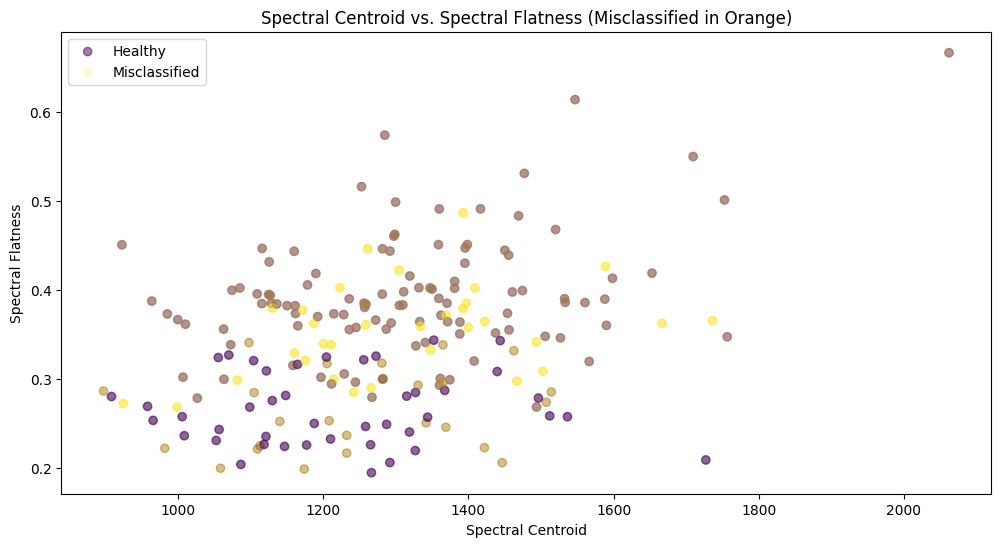

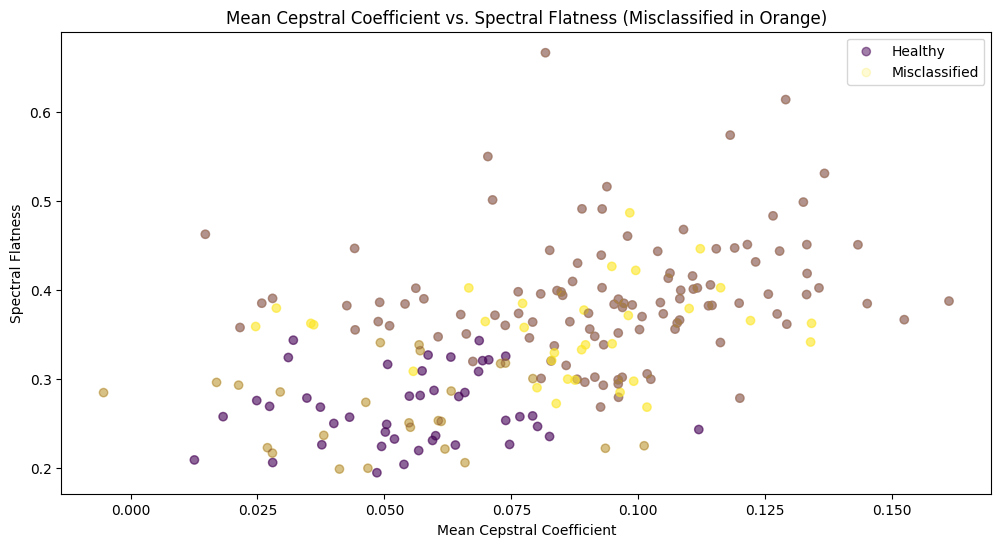

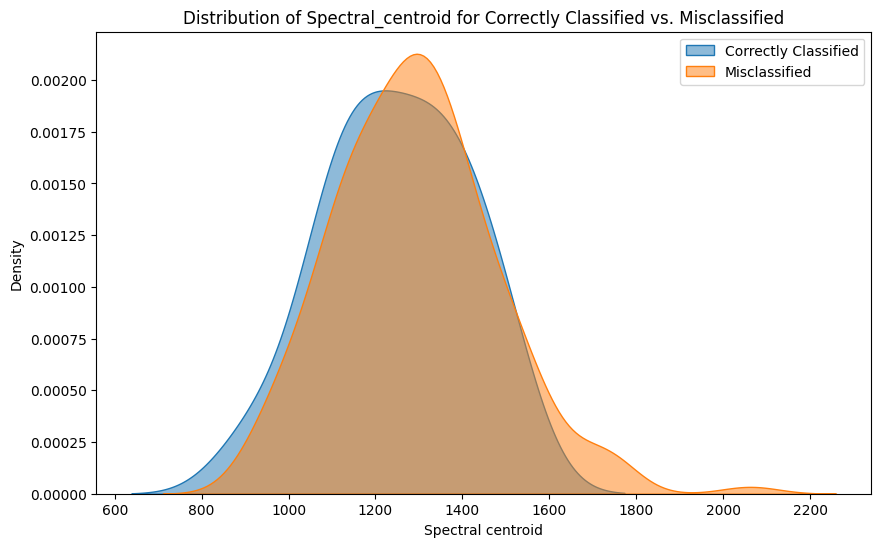

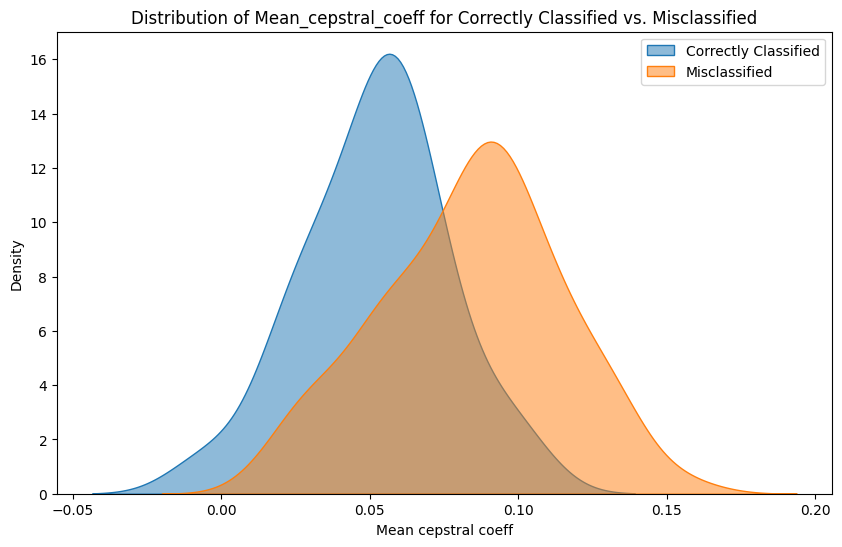

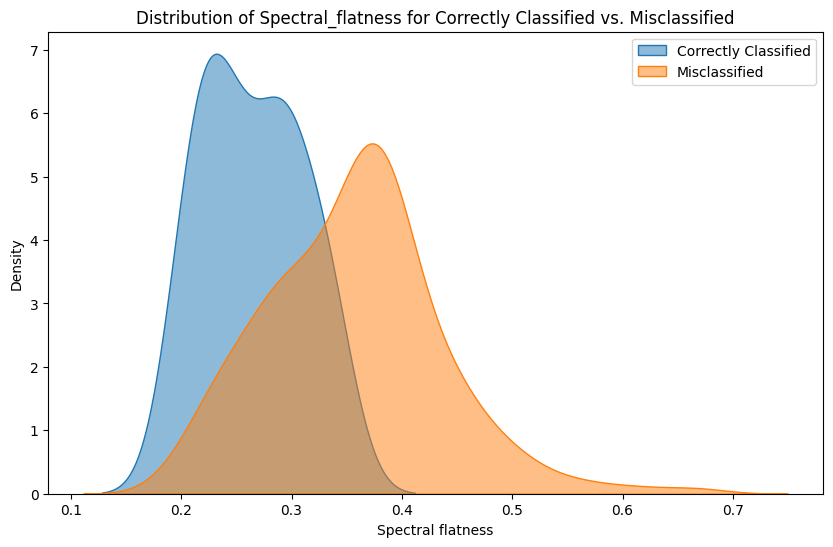

In [ ]:

plt.figure(figsize=(12, 6))
plt.scatter(results_df['spectral_centroid'], results_df['spectral_flatness'], c=(results_df['diagnosis'] == 'healthy'), alpha=0.5, label='Healthy')
plt.scatter(results_df['spectral_centroid'], results_df['spectral_flatness'], c=(results_df['refined_predicted_class'] != 'healthy'), alpha=0.2, label='Misclassified')
plt.xlabel('Spectral Centroid')
plt.ylabel('Spectral Flatness')
plt.title('Spectral Centroid vs. Spectral Flatness (Misclassified in Orange)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(results_df['mean_cepstral_coeff'], results_df['spectral_flatness'], c=(results_df['diagnosis'] == 'healthy'), alpha=0.5, label='Healthy')
plt.scatter(results_df['mean_cepstral_coeff'], results_df['spectral_flatness'], c=(results_df['refined_predicted_class'] != 'healthy'), alpha=0.2, label='Misclassified')
plt.xlabel('Mean Cepstral Coefficient')
plt.ylabel('Spectral Flatness')
plt.title('Mean Cepstral Coefficient vs. Spectral Flatness (Misclassified in Orange)')
plt.legend()
plt.show()


misclassified = results_df[results_df['diagnosis'] != results_df['refined_predicted_class']]
correctly_classified = results_df[results_df['diagnosis'] == results_df['refined_predicted_class']]

features = ['spectral_centroid', 'mean_cepstral_coeff', 'spectral_flatness']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=correctly_classified, x=feature, label='Correctly Classified', fill=True, alpha=0.5)
    sns.kdeplot(data=misclassified, x=feature, label='Misclassified', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature.capitalize()} for Correctly Classified vs. Misclassified')
    plt.xlabel(feature.replace('_', ' ').capitalize())
    plt.ylabel('Density')
    plt.legend()
    plt.show()


Accuracy: 20.19%
Sensitivity: 50.99%
Specificity: 73.68%


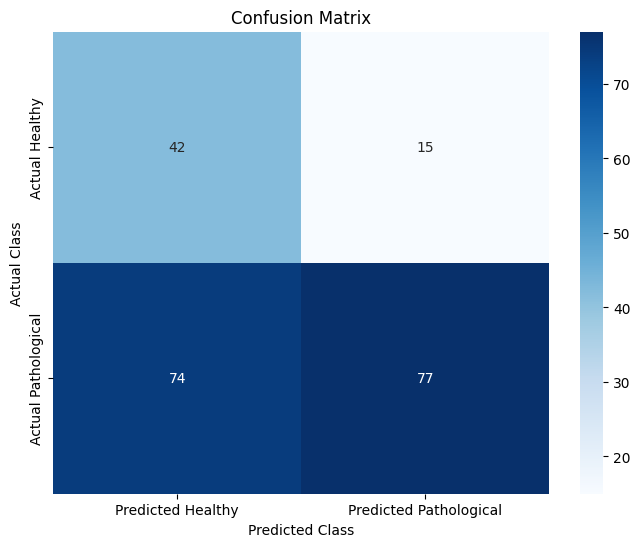

In [ ]:
def improved_classification(row):
    if row['spectral_flatness'] < 0.23:
        return 'healthy'
    elif row['spectral_flatness'] > 0.45:
        return 'pathological'
    
    if row['mean_cepstral_coeff'] > 0.09:
        return 'pathological'
    elif row['mean_cepstral_coeff'] < 0.03 and row['spectral_centroid'] < 1100:
        return 'healthy'
    
    if row['spectral_centroid'] > 1500 and row['spectral_flatness'] > 0.33:
        return 'pathological'
    
    return 'healthy'

results_df['improved_predicted_class'] = results_df.apply(improved_classification, axis=1)

# Evaluation metrics
total_samples = len(results_df)
correct_predictions = (results_df['diagnosis'] == results_df['improved_predicted_class']).sum()
accuracy = correct_predictions / total_samples

true_positives = len(results_df[(results_df['diagnosis'] != 'healthy') & (results_df['improved_predicted_class'] != 'healthy')])
false_negatives = len(results_df[(results_df['diagnosis'] != 'healthy') & (results_df['improved_predicted_class'] == 'healthy')])
true_negatives = len(results_df[(results_df['diagnosis'] == 'healthy') & (results_df['improved_predicted_class'] == 'healthy')])
false_positives = len(results_df[(results_df['diagnosis'] == 'healthy') & (results_df['improved_predicted_class'] != 'healthy')])

sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0

# Accuracy = přesnost, sensitivity = true_negative/false_negative, specificity vice versa
print(f"Accuracy: {accuracy:.2%}")
print(f"Sensitivity: {sensitivity:.2%}")
print(f"Specificity: {specificity:.2%}")



conf_matrix = pd.DataFrame(
    [[true_negatives, false_positives], 
     [false_negatives, true_positives]], 
    index=['Actual Healthy', 'Actual Pathological'],
    columns=['Predicted Healthy', 'Predicted Pathological']
)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

The column 'improved_classification' does not exist.


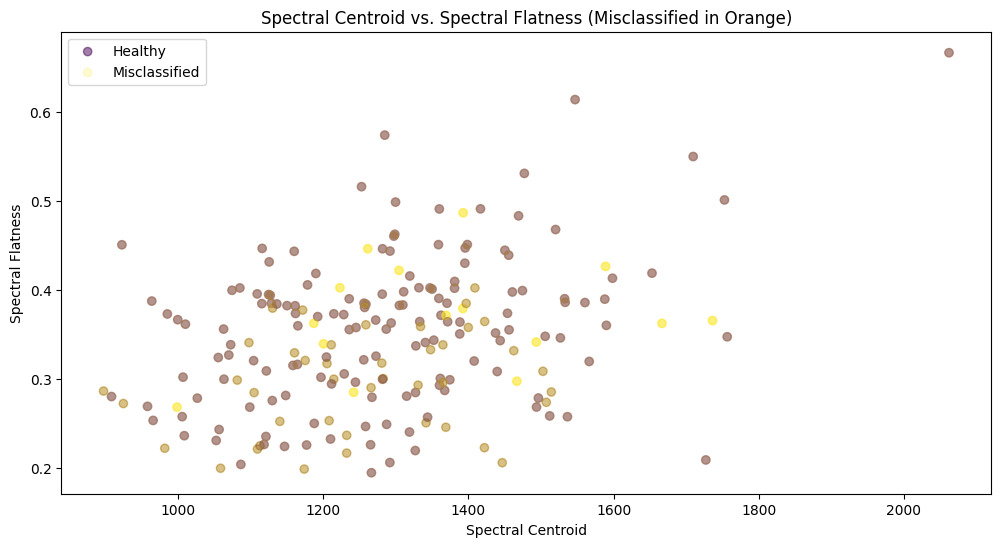

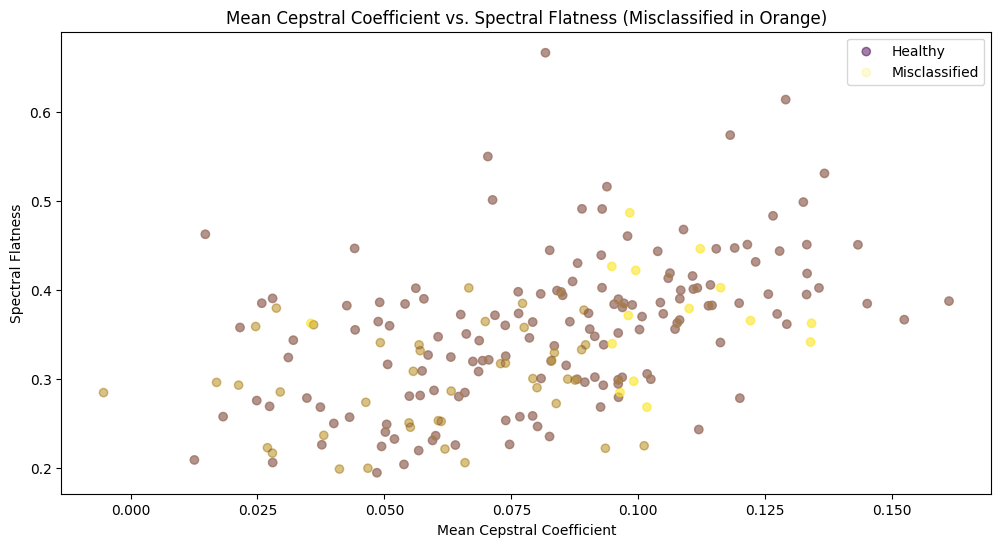

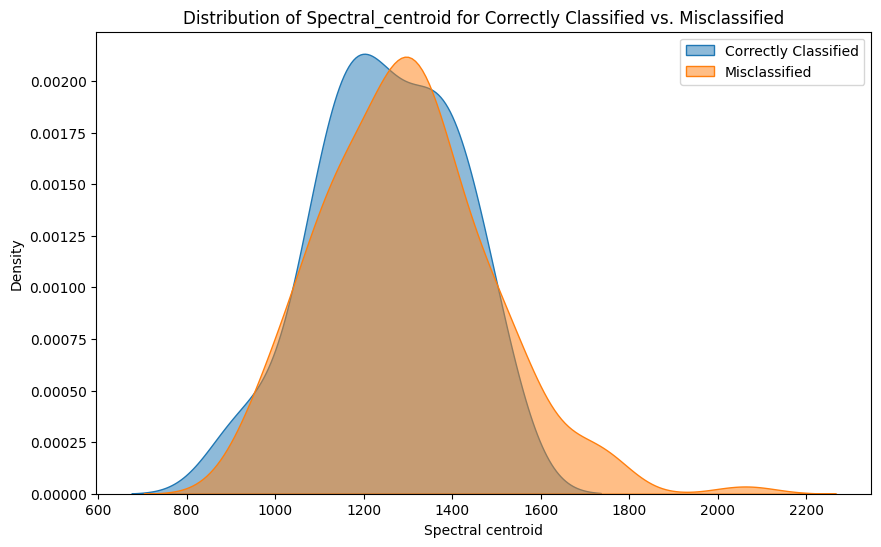

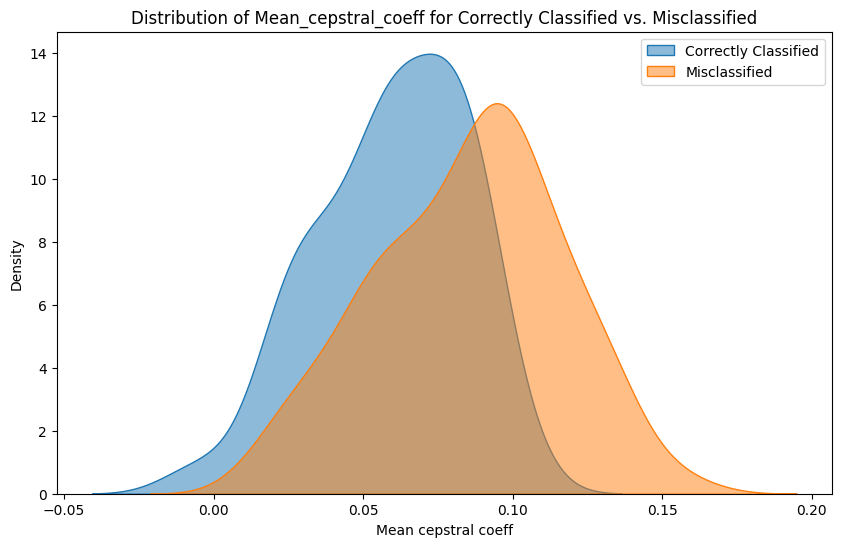

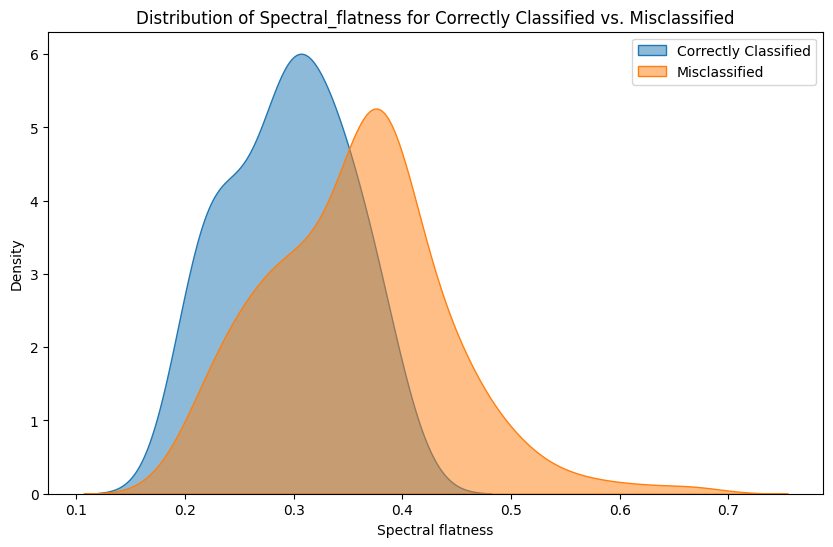

In [ ]:
if 'improved_classification' not in results_df.columns:
    print("The column 'improved_classification' does not exist.")
else:
    print("Column 'improved_classification' is available.")

results_df['improved_classification'] = results_df.apply(improved_classification, axis=1)


plt.figure(figsize=(12, 6))
plt.scatter(results_df['spectral_centroid'], results_df['spectral_flatness'], 
            c=(results_df['diagnosis'] == 'healthy'), alpha=0.5, label='Healthy')
plt.scatter(results_df['spectral_centroid'], results_df['spectral_flatness'], 
            c=(results_df['improved_classification'] != results_df['diagnosis']), alpha=0.2, label='Misclassified')
plt.xlabel('Spectral Centroid')
plt.ylabel('Spectral Flatness')
plt.title('Spectral Centroid vs. Spectral Flatness (Misclassified in Orange)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(results_df['mean_cepstral_coeff'], results_df['spectral_flatness'], 
            c=(results_df['diagnosis'] == 'healthy'), alpha=0.5, label='Healthy')
plt.scatter(results_df['mean_cepstral_coeff'], results_df['spectral_flatness'], 
            c=(results_df['improved_classification'] != results_df['diagnosis']), alpha=0.2, label='Misclassified')
plt.xlabel('Mean Cepstral Coefficient')
plt.ylabel('Spectral Flatness')
plt.title('Mean Cepstral Coefficient vs. Spectral Flatness (Misclassified in Orange)')
plt.legend()
plt.show()



misclassified = results_df[results_df['diagnosis'] != results_df['improved_classification']]
correctly_classified = results_df[results_df['diagnosis'] == results_df['improved_classification']]

features = ['spectral_centroid', 'mean_cepstral_coeff', 'spectral_flatness']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=correctly_classified, x=feature, label='Correctly Classified', fill=True, alpha=0.5)
    sns.kdeplot(data=misclassified, x=feature, label='Misclassified', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature.capitalize()} for Correctly Classified vs. Misclassified')
    plt.xlabel(feature.replace('_', ' ').capitalize())
    plt.ylabel('Density')
    plt.legend()
    plt.show()
